# Week 3 - Project 2

### Team 5

#### Goal:
1. Identify a large 2-node network.  Your data should consist of ties between and not within two (or more) distinct groups.
2. Reduce the size of the network using a method (ex. island method)
3. What can you infer about each of the distinct groups?


### 1. Importing our 2-node network
The Facebook-like Forum Network was attained from the Tore Opsahl website: https://toreopsahl.com/datasets/#online_forum_network. The data represents an two-mode network among 899 users and 522 topics, where the connections are weighted on the ties based on the number of messages or characters that a user posted to a topic.

In [29]:
import networkx as net
import csv
import pandas as pd
import requests
import io
import math
import community
import numpy as np
import networkx.algorithms.bipartite as bi
import matplotlib.pyplot as plt
%matplotlib inline

request = requests.get("https://raw.githubusercontent.com/Galanopoulog/DATA620-Project-2/master/p2_data.csv").content
data = pd.read_csv(io.StringIO(request.decode('utf-8')))

In [3]:
data.head()

,user,topic,weight
0,1,1,1
1,1,39,9
2,1,102,2
3,1,154,1
4,1,357,5


In [6]:
# Entering data as nodes and edges
fb_csv = csv.reader(open('p2_data.csv'))
users = []
topics = []
fb_g = net.Graph()

for row in fb_csv:
    if row[0] not in users:
        users.append(row[0])
    if row[1] not in topics:
        topics.append(row[1])
    fb_g.add_edge(row[0], row[1], weight = row[2])

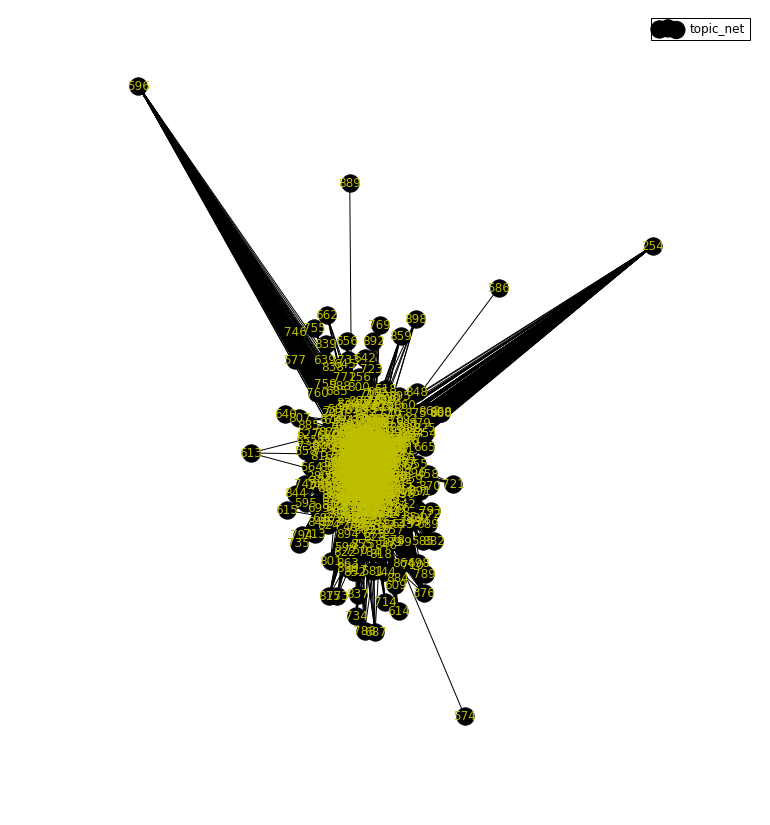

In [5]:
# Entire plot
plt.figure(figsize=(10,11))
topic_net = bi.weighted_projected_graph(fb_g, topics, ratio=False)
weights = [math.log(edata['weight'])for f,t,edata in topic_net.edges(data=True)]

net.draw_spring(topic_net, label = 'topic_net', node_color='k',with_labels=True,node_size =300,font_color ='y')
plt.legend(["topic_net"])
plt.show()

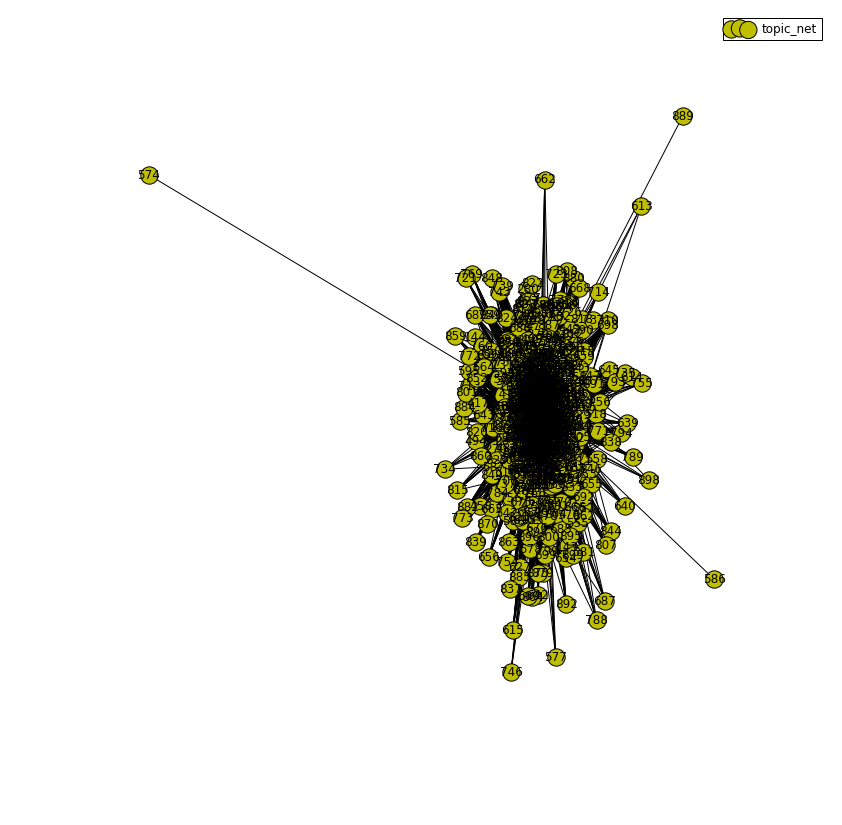

In [10]:
# Subgraph of topics
plt.figure(figsize=(11,11))
topic_net = bi.weighted_projected_graph(fb_g, topics, ratio=False)
topic_net = max(net.connected_component_subgraphs(topic_net),key=len)
weights = [math.log(edata['weight'])for f,t,edata in topic_net.edges(data=True)]

net.draw_spring(topic_net, label = 'topic_net', node_color='y',with_labels=True,node_size =300,font_color ='k')
plt.legend(["topic_net"])
plt.show()

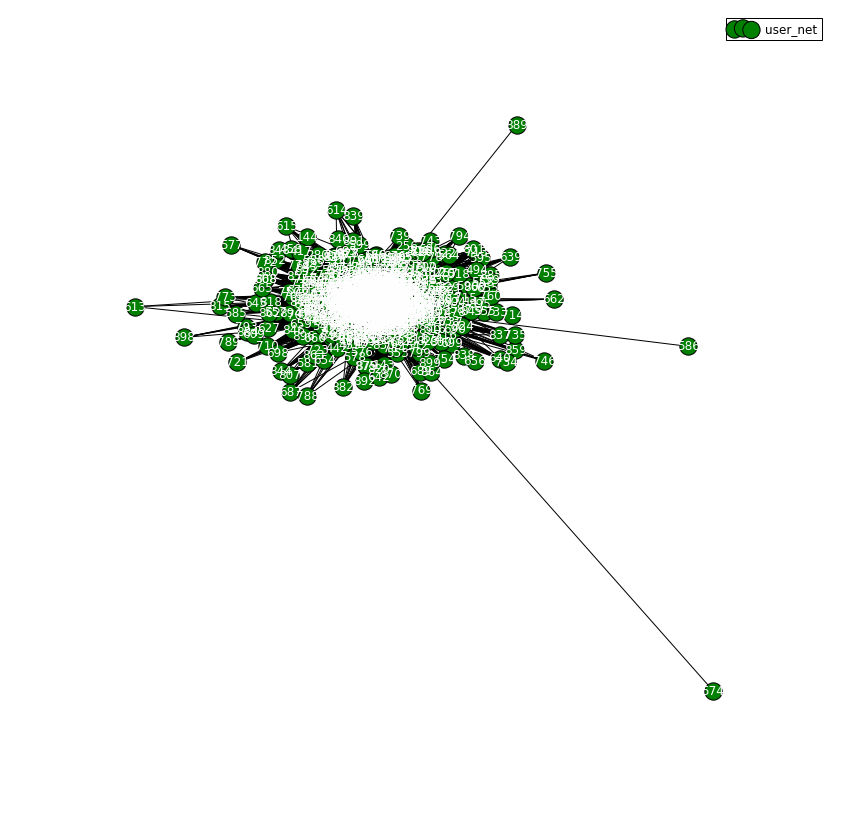

In [11]:
# Subgraph of users
plt.figure(figsize=(11,11))
user_net = bi.weighted_projected_graph(fb_g, users, ratio=False)
user_net = max(net.connected_component_subgraphs(user_net),key=len)
weights = [math.log(edata['weight'])for f,t,edata in user_net.edges(data=True)]

net.draw_spring(topic_net, label = 'user_net', node_color='g', with_labels=True, node_size =300, font_color ='w')
plt.legend(["user_net"])
plt.show()

### 2. Reducing the Network

In [12]:
# Trimming edges based on edge weight
def trim_edges(fb_g, weight=1):
    fb_g2 = net.Graph()
    for f, to, edata in fb_g.edges(data=True):
        if edata['weight']> weight:
            fb_g2.add_edge(f,to,edata)
    return fb_g2

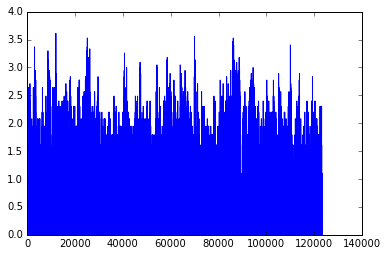

In [13]:
plt.plot(weights)

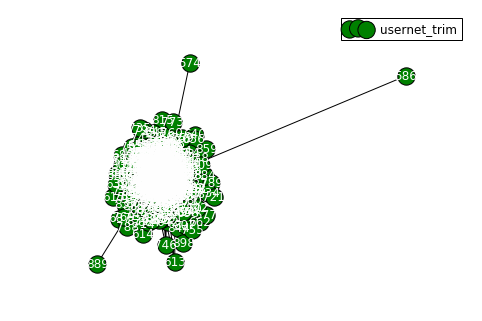

In [19]:
usernet_trim = trim_edges(user_net,weight= math.exp(0.99))
weights = [edata['weight'] for f,t,edata in usernet_trim.edges(data=True)]

net.draw_spring(topic_net, label = 'usernet_trim', node_color='g',with_labels=True,node_size =300,font_color ='w')
plt.legend(["usernet_trim"])
plt.show()

In [21]:
## Raising the water level based on min and max values
weights= [edata['weight'] for f,to,edata in usernet_trim.edges(data=True)]
mn = int(min(weights))
mx = int(max(weights))

In [22]:
# Island method
def island_method(usernet_trim, iterations=10):
    step =((mx - mn)/iterations)
    return [[threshold, trim_edges(usernet_trim, threshold)] for threshold in np.arange(mn,mx,step)]

In [24]:
cc = list(net.connected_component_subgraphs(usernet_trim))
# Removing nodes with no edges
ccn=[]
j=0
for i in range(len(cc)):
    if (len(net.edges(cc[i]))!=0):
        ccn.insert(j,cc[i])
        j=j+1
len(ccn)

1

In [31]:
for i in range(len(ccn)) :
    islands = island_method(ccn[i])
    if islands is not None:
        for j in range(len(islands)):
            print ('Subgraph:',i, 'Weight :', islands[j][0] , '# Nodes:', len(net.nodes(islands[j][1])))

('Subgraph:', 0, 'Weight :', 3, '# Nodes:', 585)
('Subgraph:', 0, 'Weight :', 6, '# Nodes:', 347)
('Subgraph:', 0, 'Weight :', 9, '# Nodes:', 187)
('Subgraph:', 0, 'Weight :', 12, '# Nodes:', 112)
('Subgraph:', 0, 'Weight :', 15, '# Nodes:', 66)
('Subgraph:', 0, 'Weight :', 18, '# Nodes:', 37)
('Subgraph:', 0, 'Weight :', 21, '# Nodes:', 27)
('Subgraph:', 0, 'Weight :', 24, '# Nodes:', 18)
('Subgraph:', 0, 'Weight :', 27, '# Nodes:', 14)
('Subgraph:', 0, 'Weight :', 30, '# Nodes:', 8)
('Subgraph:', 0, 'Weight :', 33, '# Nodes:', 8)
('Subgraph:', 0, 'Weight :', 36, '# Nodes:', 2)


We have one subraph, so centrality measures may be better at identifying network dynamics.

### 3. Inferences About Groups

In [12]:
# Function defined sorted_map for sorting books based on their centrality value
def sorted_map(map):
    ms= sorted(map.iteritems(),key=lambda(k,v):(-v,k))
    return ms

In [13]:
# Compute Degree Measure
d = net.degree(usernet_trim)
ds = sorted_map(d)
ds[0:10]

[('100', 458),
 ('13', 430),
 ('67', 425),
 ('18', 407),
 ('164', 403),
 ('82', 392),
 ('12', 379),
 ('10', 344),
 ('47', 340),
 ('377', 337)]

In [14]:
# Is the graph directed?
user_ud = usernet_trim.to_undirected()
fb_components = net.connected_component_subgraphs(user_ud)
net.is_directed(user_ud)

False

In [15]:
#Find Communities 
part = community.best_partition(user_ud)
mod = community.modularity(part, user_ud)

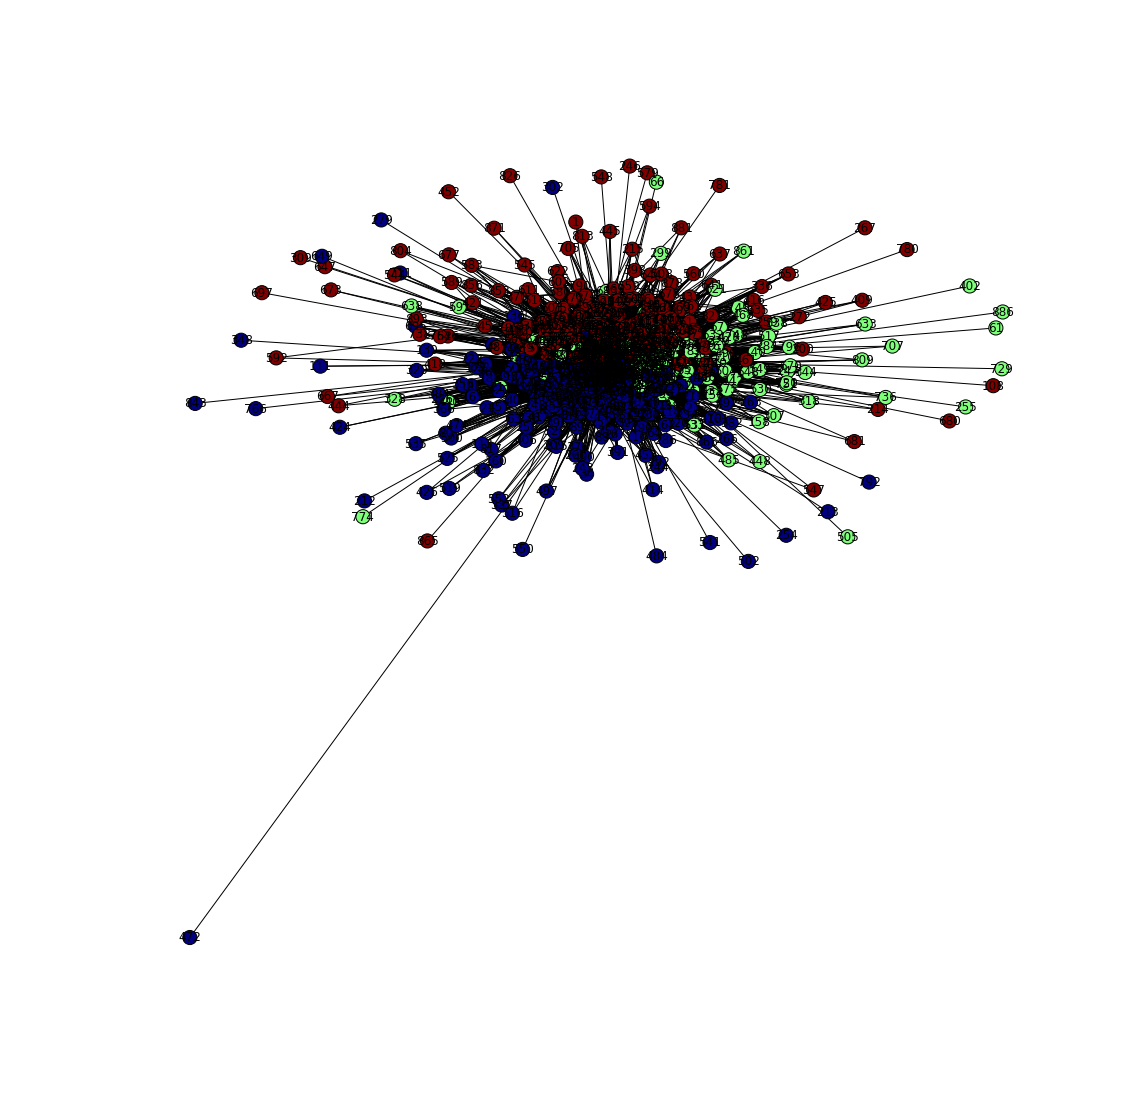

In [16]:
values = [part.get(node) for node in user_ud.nodes()]
plt.figure(figsize=(15,15))
pos = net.drawing.spring_layout(user_ud)
net.draw(user_ud, pos, cmap=plt.get_cmap('jet'), node_color = values, node_size=200, with_labels=True)

In [17]:
# Examine node data to determine top user centralities
print user_ud.nodes(data=True)[0:5]

[('198', {}), ('344', {}), ('819', {}), ('346', {}), ('347', {})]


In [18]:
user_ud = fb_g

# Degree Centrality
dcent = net.degree_centrality(user_ud)
dcent_s = sorted_map(dcent)
dcent_s[0:19]

[('10', 0.14253897550111358),
 ('13', 0.1358574610244989),
 ('67', 0.12583518930957682),
 ('164', 0.11358574610244988),
 ('82', 0.11358574610244988),
 ('100', 0.11135857461024498),
 ('75', 0.10690423162583518),
 ('12', 0.10579064587973273),
 ('18', 0.10244988864142539),
 ('59', 0.09688195991091314),
 ('91', 0.09354120267260578),
 ('19', 0.08797327394209353),
 ('208', 0.08797327394209353),
 ('290', 0.08017817371937638),
 ('20', 0.07906458797327394),
 ('291', 0.0779510022271715),
 ('16', 0.07683741648106904),
 ('194', 0.07461024498886414),
 ('228', 0.07238307349665923)]

In [19]:
# Closeness Centrality
ccent = net.closeness_centrality(user_ud)
ccent_s = sorted_map(ccent)
ccent_s[0:19]

[('67', 0.4838362068965517),
 ('13', 0.48357565966612814),
 ('100', 0.4825362708221386),
 ('82', 0.47437929212889596),
 ('10', 0.47362869198312235),
 ('18', 0.4696652719665272),
 ('12', 0.4684402712571727),
 ('164', 0.4669786791471659),
 ('290', 0.4631253223310985),
 ('75', 0.460276781137878),
 ('377', 0.45816326530612245),
 ('59', 0.45560629122272955),
 ('47', 0.4535353535353535),
 ('16', 0.45330641090358403),
 ('19', 0.4496745117676515),
 ('228', 0.4481037924151697),
 ('91', 0.44788029925187034),
 ('208', 0.44433448787728846),
 ('319', 0.44433448787728846)]

In [20]:
# Betweenness Centrality
bcent = net.betweenness_centrality(user_ud)
bcent_s = sorted_map(bcent)
bcent_s[0:19]

[('10', 0.0491356156440861),
 ('13', 0.04402628258657196),
 ('67', 0.04057015515378935),
 ('59', 0.037753469942121046),
 ('82', 0.03440957042205271),
 ('75', 0.031653867253450756),
 ('12', 0.0304361571456013),
 ('164', 0.029677155751171892),
 ('100', 0.027598595532475765),
 ('18', 0.025884482395705087),
 ('208', 0.02281380607028697),
 ('91', 0.022327200831591704),
 ('194', 0.022233924327200266),
 ('19', 0.019897884928156185),
 ('291', 0.019794648056681016),
 ('8', 0.0188350668585155),
 ('290', 0.01826645372461677),
 ('252', 0.014965282914908335),
 ('16', 0.014952602826884882)]

In [21]:
# Top 0 nodes for each Centrality
TopD = [item[0] for item in dcent_s[0:19]]
TopB = [item[0] for item in bcent_s[0:19]]
TopC = [item[0] for item in ccent_s[0:19]]
TopNodes = TopD + TopB + TopC

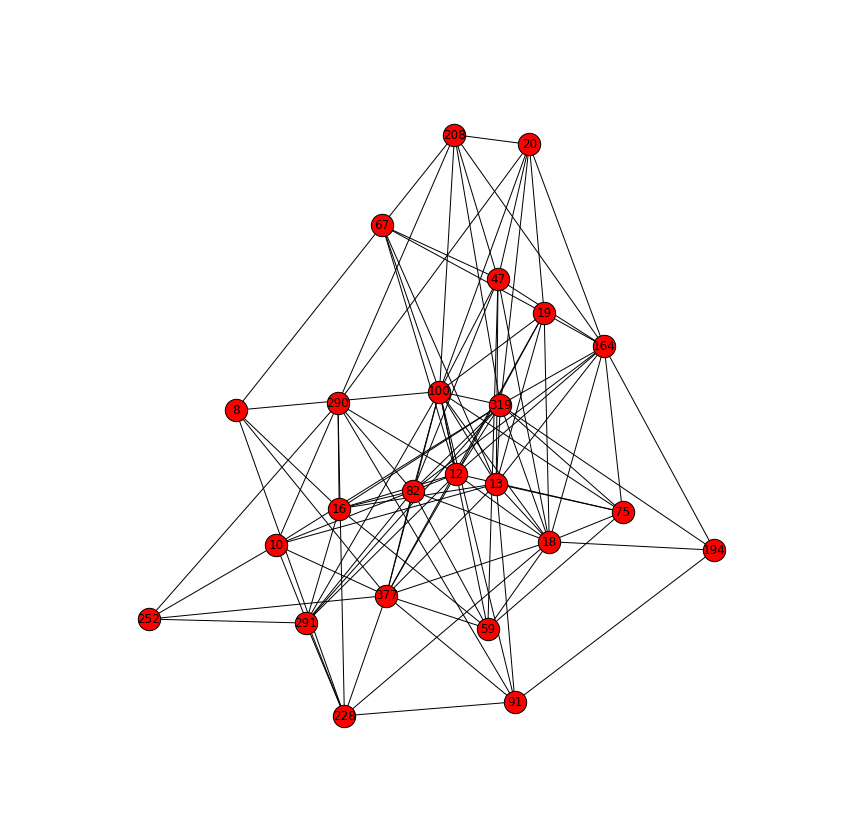

In [23]:
# Subgraph of Most Central Individuals
plt.figure(figsize=(11,11))
G = net.Graph(user_ud)

nodes = G.nodes()
edges = G.edges()

H = net.path_graph(903)
H.add_nodes_from(G)
H.add_edges_from(G.edges())

H2 = H.subgraph(TopNodes)
centralcenter = net.center(H2)
       
net.draw(H2, with_labels=True, node_color = "r", node_size = 500)